# Cousera - IBM Data Scientist Specialization
## Capstone Project

#### This notebook will be used for development of the Capstone Project within the Professional Data Scientist Certification specialization in Coursera
##### by Juliano Garcia

In [1]:
# Importing basic libraries
import pandas as pd
import numpy as np

In [2]:
print('Hello Capstone Project Course!')

Hello Capstone Project Course!


## Importing and cleaning the dataset  
#### Toronto, Canada: Neighbourhood, Borough and Postcode information

In [3]:
# Importing html scraper: BeatifulSoup
from bs4 import BeautifulSoup

# Importing html parser: lxml
import lxml

# Importing requests library
import requests

# Importing the geocoder library (not working)
#import geocoder # import geocoder

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# library to handle JSON files
import json

# Iteration tools library
import itertools

Our Dataset is a table in a wikipedia page:  
https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M  
  
Below is the first 5 lines of the table:  

<table class="wikitable sortable">
<tbody><tr>
<th>Postcode</th>
<th>Borough</th>
<th>Neighbourhood
</th></tr>
<tr>
<td>M1A</td>
<td>Not assigned</td>
<td>Not assigned
</td></tr>
<tr>
<td>M2A</td>
<td>Not assigned</td>
<td>Not assigned
</td></tr>
<tr>
<td>M3A</td>
<td><a href="/wiki/North_York" title="North York">North York</a></td>
<td><a href="/wiki/Parkwoods" title="Parkwoods">Parkwoods</a>
</td></tr>
<tr>
<td>M4A</td>
<td><a href="/wiki/North_York" title="North York">North York</a></td>
<td><a href="/wiki/Victoria_Village" title="Victoria Village">Victoria Village</a>
</td></tr>
</table>

Let's parse the url to scrap the data

In [4]:
# Parsing the webpage url
html_page = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(html_page, 'lxml')

# Getting the postcodes table
table = soup.find('table')

Now we'll create a Numpy array with the values of the table.  
First let's get the header names with the html tag '< th >'

In [5]:
# Let's get the table headers
columns = []
for col in table.find_all('th'):
    columns.append(col.text)

# Eliminates the '\n' at the end of the last string
columns[-1] = columns[-1][:-1]
columns

['Postcode', 'Borough', 'Neighbourhood']

Now we get the values in the lines, each row is encompassed between a < tr > tag while each column value of that row is inside of a < td > tag

In [6]:
# Initializing an array with the column headers
table_array = np.array([columns])

# Iterate throu all the lines in the table
for i, lin in enumerate(table.find_all('tr')):
    if i != 0: # Ignores first row since it is the headers
        line = []
        for j, val in enumerate(lin.find_all('td')):
            val = val.text
            if j == 2: # Eliminates the '/n' at the end of all the last column values
                val = val[:-1]
            line.append(val)
        table_array = np.append(table_array, [line], axis=0)

# Now let's convert the array into a pandas dataframe with the first line as headers
df = pd.DataFrame(table_array[1:, :], columns=table_array[0,:])
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


#### Great! We have our raw table, now let's clean it!

In [7]:
# Eliminating the Not assigned Borough rows
df = df[df['Borough'] != 'Not assigned']
df.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


In order to group by Postcode so we only have uniques Postcodes in the dataset, let's concatenate the names of the neighbourhood  
First let's create a a function and apply it to the groupby dataset

In [8]:
# Creates a function to concatenate the Neighbouhood names when grouping by Postcode
def group_postcode(x):
     return pd.Series({'Borough' : x['Borough'].values[0], 
                       'Neighbourhood' : "%s" % ', '.join(x['Neighbourhood'])})

In [9]:
df = df.groupby('Postcode').apply(group_postcode)
df.reset_index(inplace=True)
df.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Now, do we have any "Not assigned" neighbourhoods? If so, let's replace it with the Borough name

In [10]:
pd.Series(df['Neighbourhood'] == 'Not assigned').sum()

1

In [11]:
df['Neighbourhood'].replace('Not assigned', df['Borough'], inplace=True)
df.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [12]:
pd.Series(df['Neighbourhood'] == 'Not assigned').sum()

0

In [13]:
df.shape

(103, 3)

_______
## Next Submission

#### Perfect! Now let's get the latitudes and longitudes of each Postcode!

The below cell loads a csv file loaded in a IBM storage object, the cell is hidden since it contains authentication credentials  
This is a workarround since the geocoder library failed to load the geo points of the dataframe

In [14]:
# The code was removed by Watson Studio for sharing.

,Latitude,Longitude
Postal Code,,
M1B,43.806686,-79.194353
M1C,43.784535,-79.160497
M1E,43.763573,-79.188711
M1G,43.770992,-79.216917
M1H,43.773136,-79.239476


Now let's join the 2 dataframes

In [15]:
df = df.join(geos, on='Postcode')
df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


_____
## Next Submission

Now let's the Fourquare API and K-means algorithms to identify similiar neighbourhoods

Let's use just the neighbourhood that have the word Toronto as borough for now

In [16]:
df['Borough'].value_counts()

North York          24
Downtown Toronto    18
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
York                 5
East York            5
East Toronto         5
Mississauga          1
Queen's Park         1
Name: Borough, dtype: int64

In [17]:
df_tor = df[df['Borough'].str.contains("Toronto")]
df_tor.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


#### Using GeoPy library to get the Latitude and Longitude of Toronto

In [18]:
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

In [19]:
# Gettting the central point for Toronto, used for folium map starting point
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode('Toronto, ON')
latitude = location.latitude
longitude = location.longitude

# Let's see if if was sucessfully
(latitude, longitude)

(43.653963, -79.387207)

Let's see how the neighbourhood in Toronto looks like

In [20]:
#!conda install -c conda-forge folium=0.5.0 --yes
import folium

In [21]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(df_tor['Latitude'], df_tor['Longitude'], df_tor['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.6,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Now we should start using the Foursquare API to get venue infos about the neighbourhoods

The below cell declares the Client ID and Secret variables for the API access, it is hidden in order to protect the credentials  
Used version: 20190601

In [22]:
# The code was removed by Watson Studio for sharing.

Creating a function to get the venues on all the neighborhoods in Toronto

In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    '''
    This function resturn all the nearby venues whithin radius of a given neighborhood name, latitude and longitude
    '''
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # Creates the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # Makes the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # Returns only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    # Now let's build the output DataFrame
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now let's create a new dataframe "toronto_venues" with all the nearby venues of the selected neighborhoods

In [24]:
toronto_venues = getNearbyVenues(names=df_tor['Neighbourhood'],
                                 latitudes=df_tor['Latitude'],
                                 longitudes=df_tor['Longitude']
                                )
print(toronto_venues.shape)
toronto_venues.head()

(1692, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
1,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
2,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
3,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant
4,"The Danforth West, Riverdale",43.679557,-79.352188,Dolce Gelato,43.677773,-79.351187,Ice Cream Shop


Let's check if we are going to have conflicting Venue names

In [25]:
pd.Series(toronto_venues['Venue Category'] == 'Neighborhood').sum()

4

Venue Category = Neighborhood will result in a grouping error, so we should eliminate those venues

In [26]:
toronto_venues = toronto_venues[toronto_venues['Venue Category'] != 'Neighborhood']

# Now let's check again
pd.Series(toronto_venues['Venue Category'] == 'Neighborhood').sum()

0

Great!

#### Now let's group the neighborhoods and have how many each vanue Category we have for each neighborhood

In [27]:
# Getting dummies for the Venue category
toronto_enc = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# Adding the 'Neighborhood' column back as the 1st column
toronto_enc = pd.concat([toronto_venues['Neighborhood'], toronto_enc], axis=1)

print(toronto_enc.shape)
toronto_enc.head()

(1688, 239)


,Neighborhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"The Danforth West, Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"The Danforth West, Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,"The Danforth West, Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [28]:
toronto_group = toronto_enc.groupby('Neighborhood').mean().reset_index()
print(toronto_group.shape)
toronto_group.head()

(38, 239)


,Neighborhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.040404,...,0.0,0.0,0.010101,0.0,0.0,0.010101,0.0,0.0,0.0,0.0
1,Berczy Park,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.017857,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,"Brockton, Exhibition Place, Parkdale Village",0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,Business Reply Mail Processing Centre 969 Eastern,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.0,0.0,0.066667,0.066667,0.066667,0.133333,0.2,0.133333,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


#### Let's create a dataframe with the top 10 most common venues in each neighborhood  
We will use it to elaborate on the clustering analysis

First, a function to sort the venues in descending order

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the dataframe

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_group['Neighborhood']

for ind in np.arange(toronto_group.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_group.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Bar,Thai Restaurant,Steakhouse,American Restaurant,Burger Joint,Hotel,Bakery,Cosmetics Shop
1,Berczy Park,Coffee Shop,Cocktail Bar,Restaurant,Seafood Restaurant,Café,Cheese Shop,Farmers Market,Beer Bar,Bakery,Steakhouse
2,"Brockton, Exhibition Place, Parkdale Village",Performing Arts Venue,Café,Breakfast Spot,Coffee Shop,Pet Store,Italian Restaurant,Burrito Place,Stadium,Caribbean Restaurant,Bar
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Gym / Fitness Center,Garden,Pizza Place,Park,Recording Studio,Restaurant,Moving Target,Burrito Place,Skate Park
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Lounge,Airport Terminal,Boat or Ferry,Boutique,Airport,Airport Food Court,Airport Gate,Harbor / Marina,Plane


### Great! Now we are ready to cluster our neighborhoods!  
#### Let's use k-means algorithm for that!

In [31]:
from sklearn.cluster import KMeans

Let's check the error on different numbers of clusters to define the optmal number

In [32]:
# Defining the attributes to be used
toronto_clustering = toronto_group.drop('Neighborhood', 1)

num_ks = list(range(1,11))
scores = []

for kclusters in num_ks:
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_clustering)
    scores.append(kmeans.score(toronto_clustering))

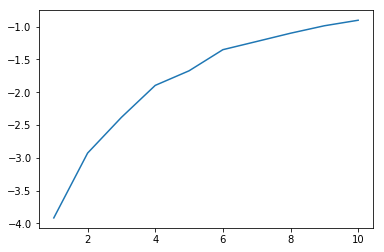

In [45]:
import matplotlib.pyplot as plt

plt.plot(num_ks, scores)

In [34]:
score_gain = {i+1 : (scores[i] - scores[i-1]) for i in range(1, len(scores))}
score_gain

{2: 0.98810632673735421,
 3: 0.54457483901836623,
 4: 0.48721521879601482,
 5: 0.2222222222222221,
 6: 0.32185644820053105,
 7: 0.125,
 8: 0.12581143080595325,
 9: 0.11354113121010501,
 10: 0.084238674924790535}

We can see that the score gain after 6 clusters is getting marginally lower  
So let's go with __6 clusters__

In [35]:
# Let's define the kmeans object with the optmal cluster number that we defined previously
kclusters = 6
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Now let's create a consolidated dataframe

In [36]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# Let's merge the toronto dataframe with the sorted venues so we have the lat, long infos along with clusters and top venues
toronto = df_tor.iloc[:,1:].join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

toronto.head()

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,East Toronto,The Beaches,43.676357,-79.293031,4,Health Food Store,Pub,Dive Bar,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store
41,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Brewery,Bakery,Juice Bar,Liquor Store,Spa
42,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,0,Sandwich Place,Park,Movie Theater,Light Rail Station,Food & Drink Shop,Brewery,Italian Restaurant,Steakhouse,Ice Cream Shop,Pub
43,East Toronto,Studio District,43.659526,-79.340923,0,Café,Coffee Shop,Bakery,Italian Restaurant,American Restaurant,Gastropub,Yoga Studio,Cheese Shop,Bookstore,Brewery
44,Central Toronto,Lawrence Park,43.728020,-79.388790,2,Park,Swim School,Bus Line,Yoga Studio,Dog Run,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space


Great, let's visualize the clustered map

In [37]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto['Latitude'], toronto['Longitude'], toronto['Neighbourhood'], toronto['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

____

### Now let's analyze each cluster

In [38]:
# Distributing all the splitted clusters datasets in a list
tor_clusters = [toronto[toronto['Cluster Labels'] == c].iloc[:, [1] + list(range(4,15))] for c in list(range(kclusters))]

### Cluster 0

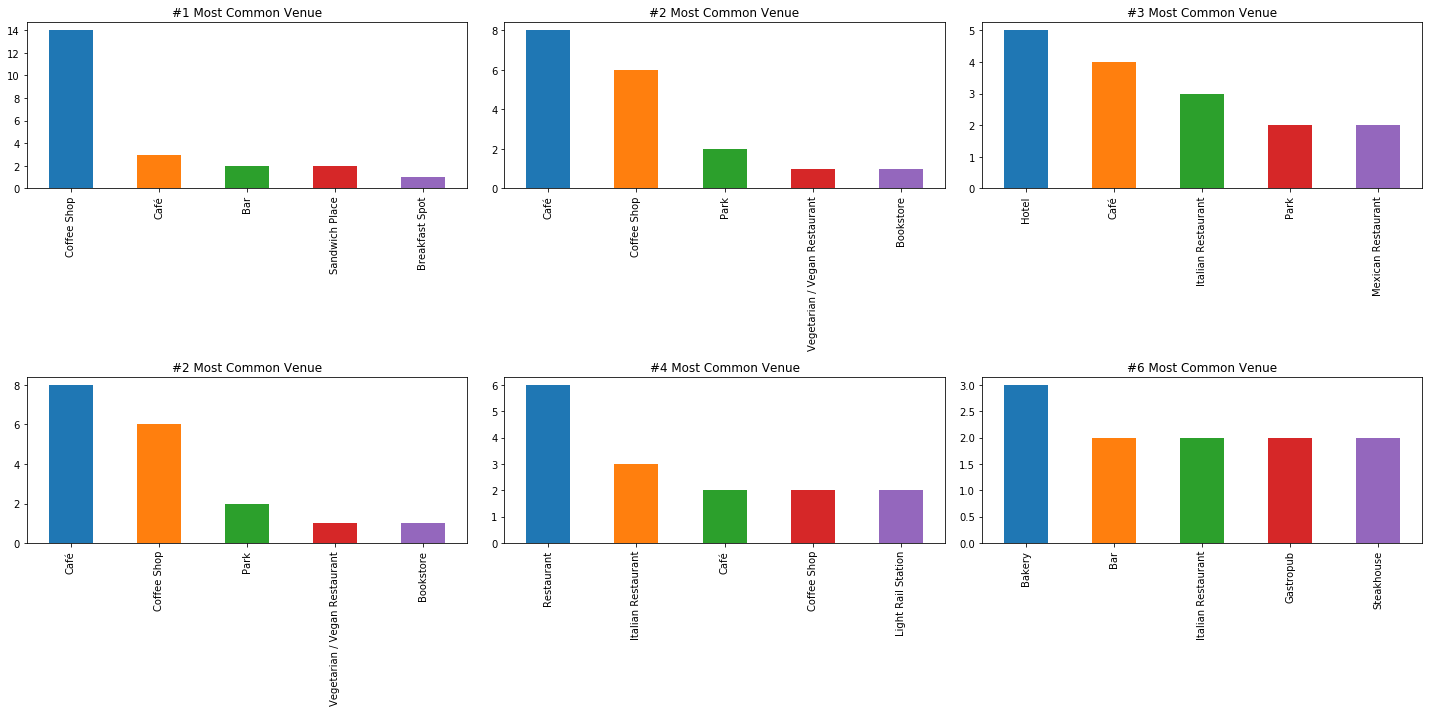

In [39]:
cluster = 0

fig, ax0 = plt.subplots(2, 3,figsize=(20,10))

for i, j in itertools.product([1,2], [1,2,3]):
    n = i*j
    tor_clusters[cluster].iloc[:,n+1].value_counts().head().plot(kind='bar',
                                                                 ax=ax0[i-1,j-1],
                                                                 title='#{} Most Common Venue'.format(n))
fig.tight_layout()

Can creally see that this cluster has a lot of coffee shops, restaurants and other venues related to gastronomy!  
We can this cluster: __Coffee & Eat Neighborhoods__

### Cluster 1

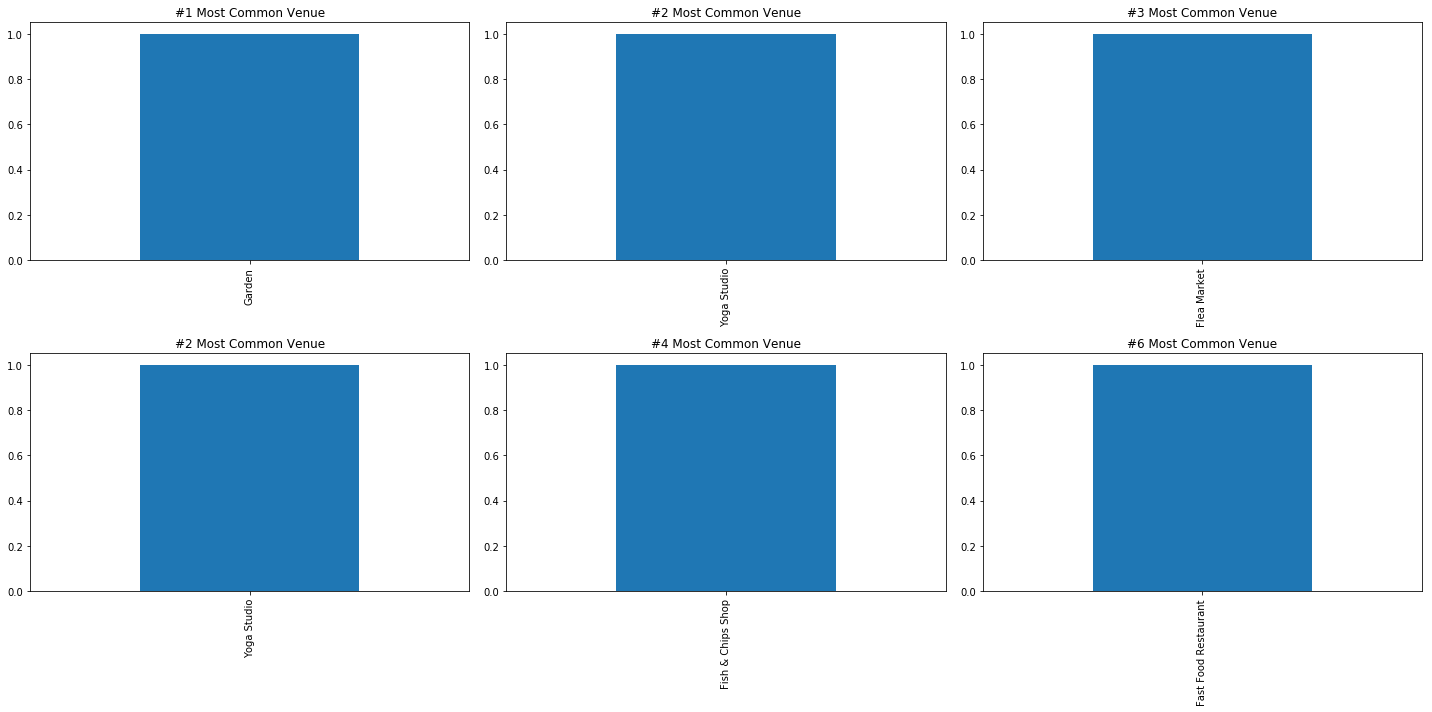

In [40]:
cluster = 1

fig, ax0 = plt.subplots(2, 3,figsize=(20,10))

for i, j in itertools.product([1,2], [1,2,3]):
    n = i*j
    tor_clusters[cluster].iloc[:,n+1].value_counts().head().plot(kind='bar',
                                                                 ax=ax0[i-1,j-1],
                                                                 title='#{} Most Common Venue'.format(n))
fig.tight_layout()

We only have one neighborhood in this cluster and we can see that its got parks and yoga studios mainly!  
So let's call this cluster __Zen Neighborhoods__

### Cluster 2

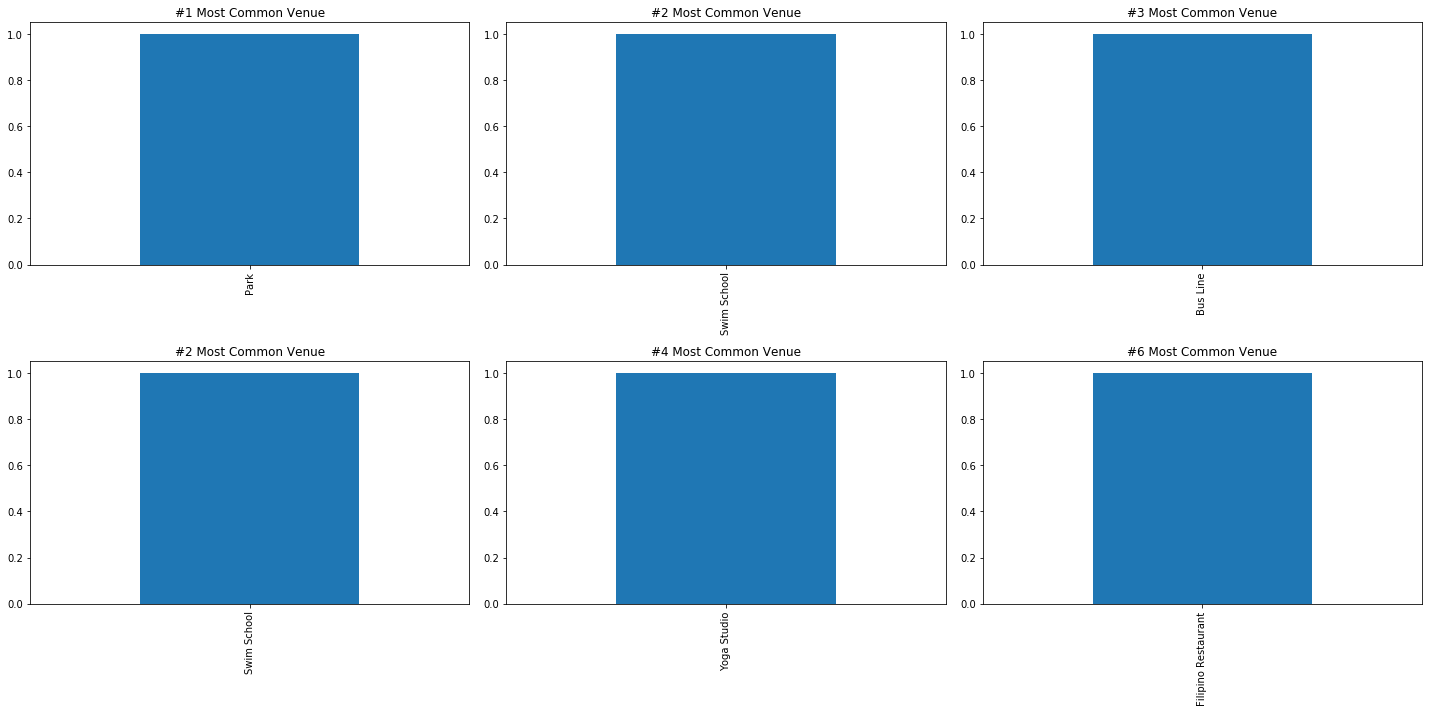

In [41]:
cluster = 2

fig, ax0 = plt.subplots(2, 3,figsize=(20,10))

for i, j in itertools.product([1,2], [1,2,3]):
    n = i*j
    tor_clusters[cluster].iloc[:,n+1].value_counts().head().plot(kind='bar',
                                                                 ax=ax0[i-1,j-1],
                                                                 title='#{} Most Common Venue'.format(n))
fig.tight_layout()

Parks and swim schools!  
Let's call it __Swimmers Neighborhoods__

### Cluster 3

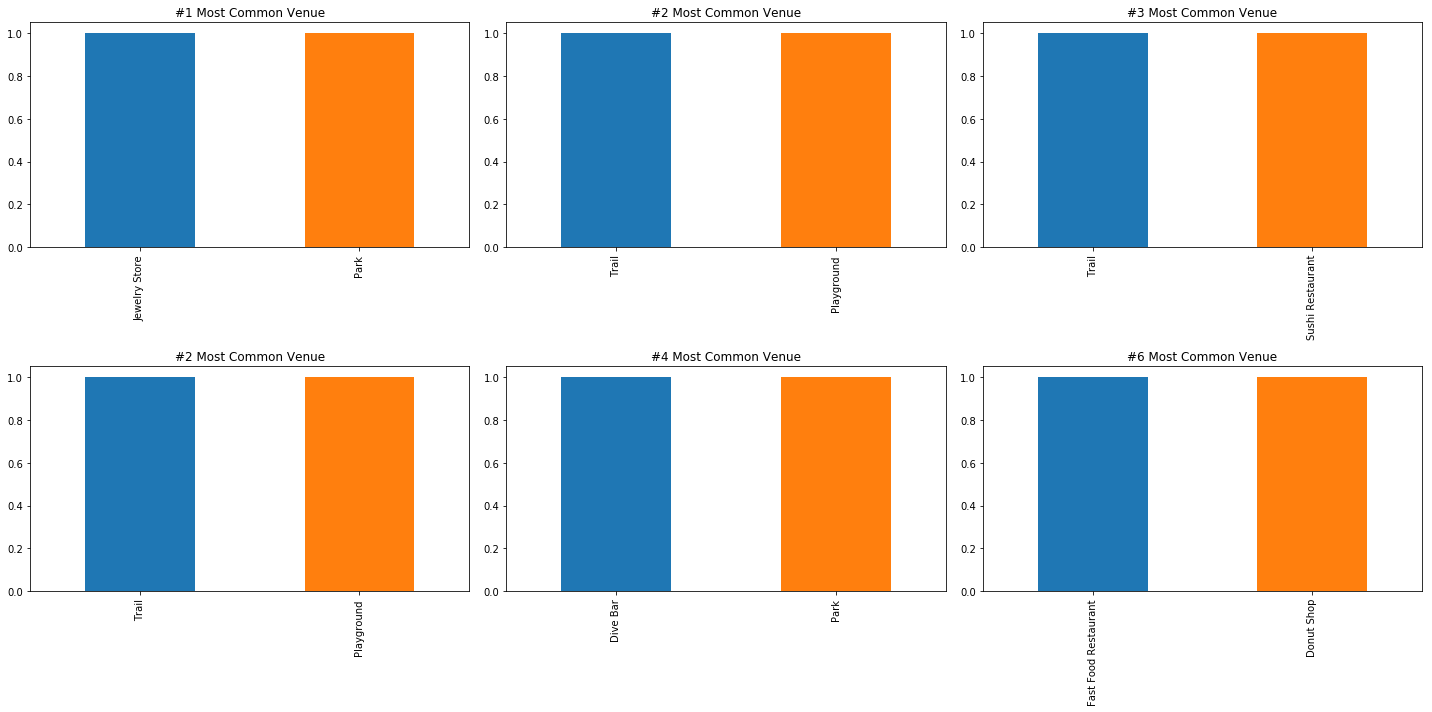

In [42]:
cluster = 3

fig, ax0 = plt.subplots(2, 3,figsize=(20,10))

for i, j in itertools.product([1,2], [1,2,3]):
    n = i*j
    tor_clusters[cluster].iloc[:,n+1].value_counts().head().plot(kind='bar',
                                                                 ax=ax0[i-1,j-1],
                                                                 title='#{} Most Common Venue'.format(n))
fig.tight_layout()

Parks, Playgrounds and Trails!  
Those are the __Adventure Neighborhoods__

### Cluster 4

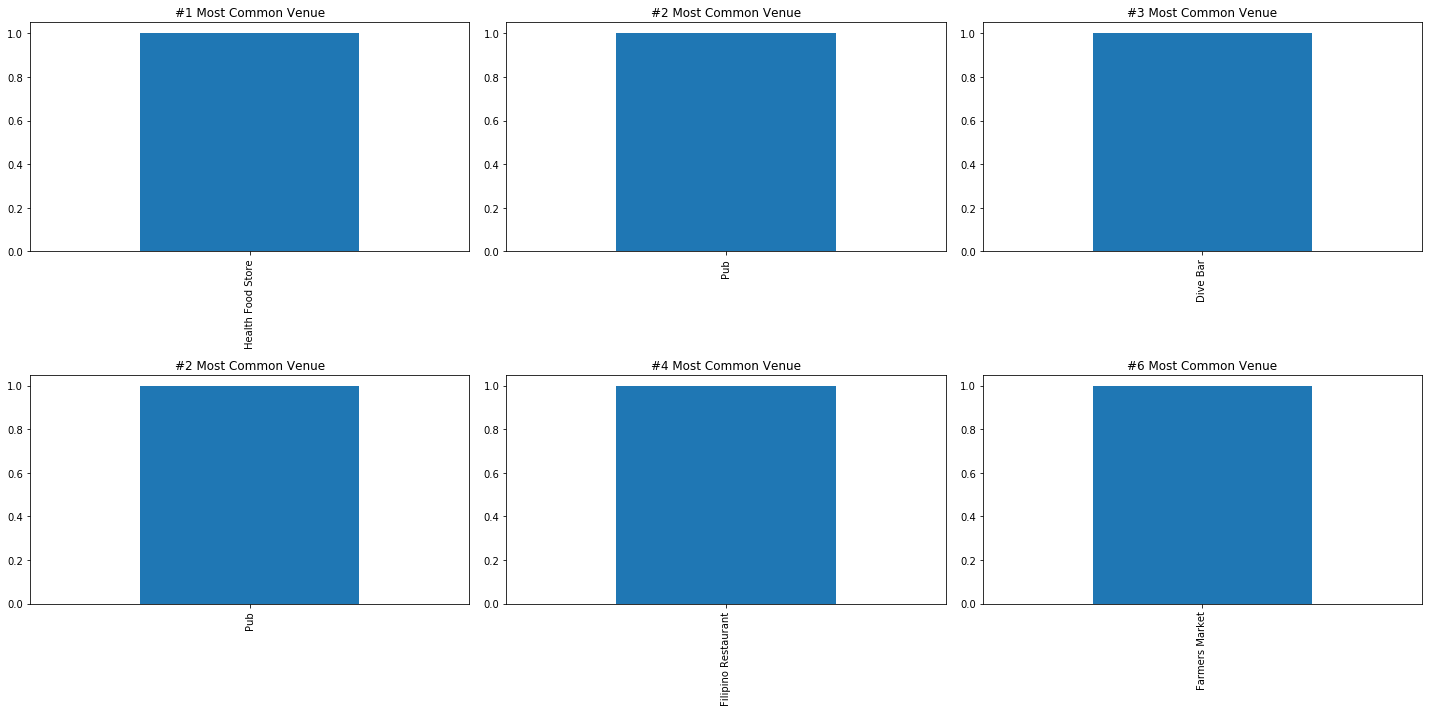

In [43]:
cluster = 4

fig, ax0 = plt.subplots(2, 3,figsize=(20,10))

for i, j in itertools.product([1,2], [1,2,3]):
    n = i*j
    tor_clusters[cluster].iloc[:,n+1].value_counts().head().plot(kind='bar',
                                                                 ax=ax0[i-1,j-1],
                                                                 title='#{} Most Common Venue'.format(n))
fig.tight_layout()

Healthy Foods and Pubs.. Interesting! no?!  
Let's call them __Healthy & Drinks Neighborhoods__

### Cluster 5

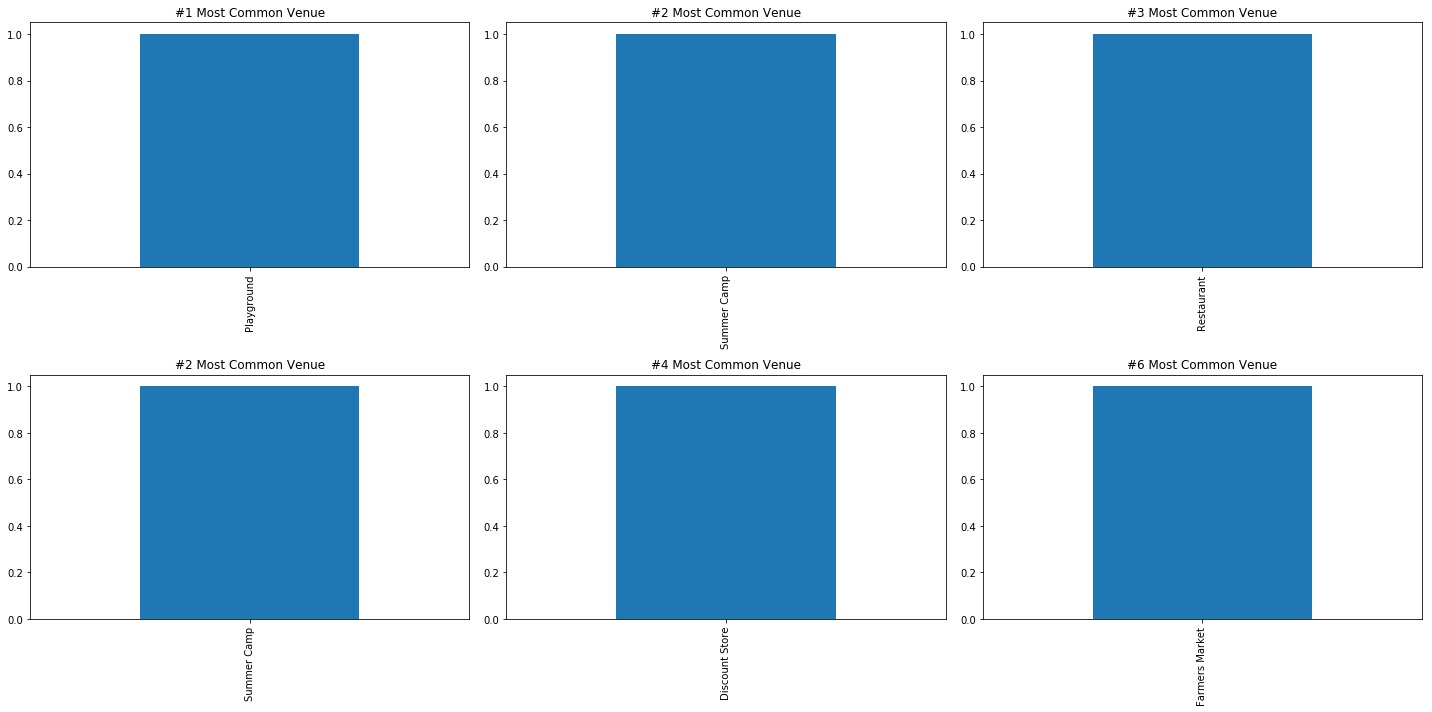

In [44]:
cluster = 5

fig, ax0 = plt.subplots(2, 3,figsize=(20,10))

for i, j in itertools.product([1,2], [1,2,3]):
    n = i*j
    tor_clusters[cluster].iloc[:,n+1].value_counts().head().plot(kind='bar',
                                                                 ax=ax0[i-1,j-1],
                                                                 title='#{} Most Common Venue'.format(n))
fig.tight_layout()

Playground, summer camp and restaurants  
How about __Vacation Neighborhoods__?